In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##### 1 task

##### 2 task

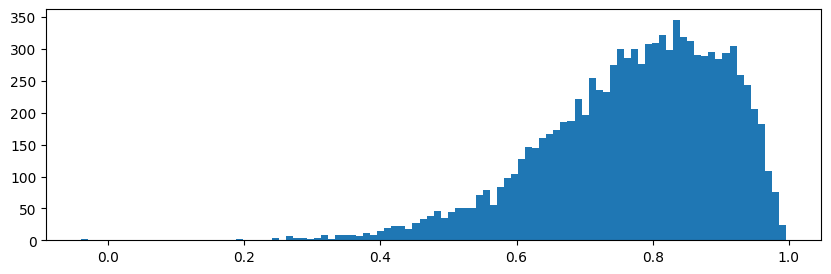

In [5]:
data = np.array([(576, 3.39), (635, 3.30), (558, 2.81), (578, 3.03), (666, 3.44),
                 (580, 3.07), (555, 3.0), (661, 3.43), (651, 3.36), (605, 3.13),
                 (653, 3.12), (575, 2.74), (545, 2.76), (572, 2.88), (594, 2.96)])

def bootstrap_corr(sample, number_of_trials):
    rng = np.random.default_rng()
    corr_arr = []
    for iteration in range(number_of_trials):
        b_sample = rng.choice(sample, size=len(sample))
        corr_coef = np.corrcoef(b_sample, rowvar=False)[0, 1]
        corr_arr.append(corr_coef)
    return corr_arr


corrs = bootstrap_corr(data, 10000)

plt.figure(figsize=(10, 3))
plt.hist(corrs, bins=100)
plt.show()

##### 3 task

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340


/home/andrey/stats/.env/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta, sigma, epsilon]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 259 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


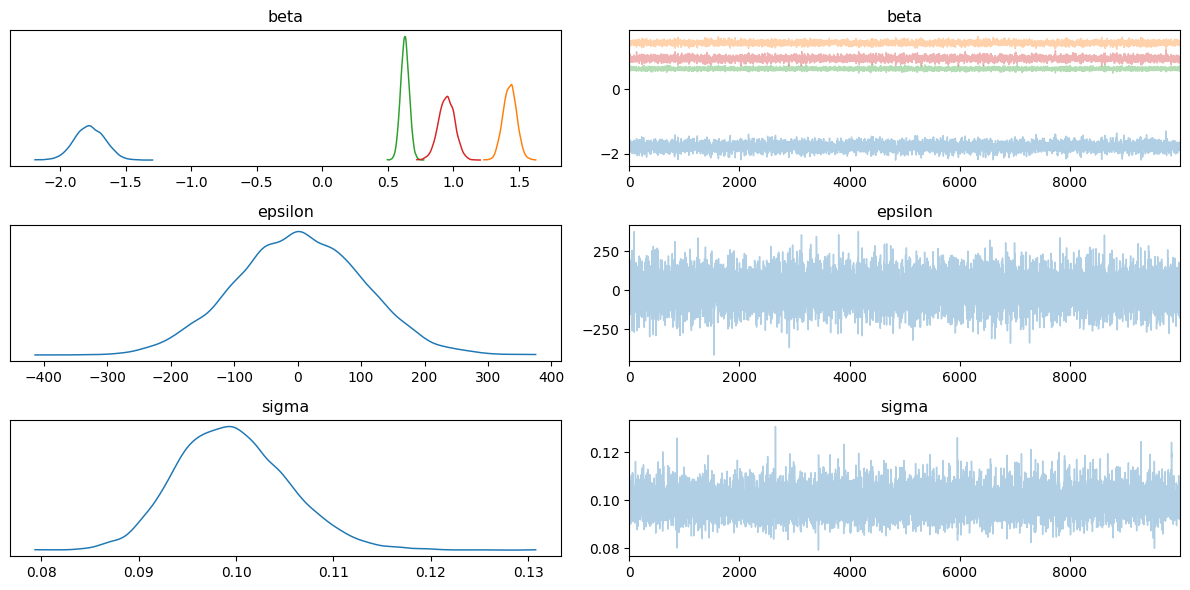

[2.96822437 3.04580928]


In [40]:
import pymc as pm
import arviz as az
data = pd.read_csv(
    'https://stepik.org/media/attachments/lesson/832665/Fish.csv')
data = data.drop(40, axis=0)
print(data.head())


model = pm.Model()

with model:
    beta = pm.Normal('beta', mu=0, sigma=100, shape=4)
    sigma = pm.HalfNormal('sigma', sigma=100)
    epsilon = pm.Normal('epsilon', mu=0, sigma=100)
    len_1 = pm.Data('len_1', data['Length1'], )
    height = pm.Data('height', data['Height'])
    width = pm.Data('width', data['Width'])
    mu = beta[0] + beta[1]*np.log(len_1) + beta[2]*np.log(height) + beta[3]*np.log(width) 
    log_weight = pm.Normal('log_weight', mu=mu, sigma=sigma, observed=np.log(data['Weight']))  
    trace = pm.sample(10000, chains=1)

az.plot_trace(trace)
plt.tight_layout()
plt.show()

beta_posterior = sum([trace['posterior']['beta'][0][:, i]
                     for i in range(1, 4)])
print(np.quantile(beta_posterior, q=[0.025, 0.975]))

##### 4 task

In [145]:
import random
from tqdm import tqdm

n = 30
w = 0.86 / 1.86
mu_m, sigma2_m = 176, 6 ** 2
mu_f, sigma2_f = 165, 5 ** 2
number_of_trials = 10000


def std_vanilla(n, w, mu_m, sigma2_m, mu_f, sigma2_f, number_of_trials):
    height_male = ss.norm(loc=mu_m, scale=np.sqrt(sigma2_m)).rvs((number_of_trials, n))
    height_female = ss.norm(loc=mu_f, scale=np.sqrt(
        sigma2_f)).rvs((number_of_trials, n))
    sex_male = ss.bernoulli(w).rvs((number_of_trials, n))
    sex_female = 1 - sex_male
    
    height =  sex_male*height_male + sex_female*height_female
    avg_arr = np.mean(height, axis=1)
    return np.std(avg_arr)
            


def std_weighted(n, w, mu_m, sigma2_m, mu_f, sigma2_f, number_of_trials):
    height_male = ss.norm(loc=mu_m, scale=np.sqrt(
        sigma2_m)).rvs((number_of_trials, n))
    height_female = ss.norm(loc=mu_f, scale=np.sqrt(
        sigma2_f)).rvs((number_of_trials, n))
    sex_male = ss.bernoulli(w).rvs((number_of_trials, n))
    sex_female = 1 - sex_male

    avg_arr = []
    for trial in range(number_of_trials):
        if sum(sex_male[trial]) == 0:
            # avg_male = np.mean(sex_male[trial]*height_male[trial])
            avg_female = np.mean(sex_female[trial]*height_female[trial])
            avg_arr.append(avg_female)
        elif sum(sex_female[trial]) == 0:
            # avg_female = np.mean(sex_female[trial]*height_female[trial])
            avg_male = np.mean(sex_male[trial]*height_male[trial])
            avg_arr.append(avg_male)
        else:
            avg_male = np.average(
                sex_male[trial]*height_male[trial], weights=sex_male[trial])
            avg_female = np.average(
                sex_female[trial]*height_female[trial], weights=sex_female[trial])
            avg_arr.append(w*avg_male + (1-w)*avg_female)
    return np.std(avg_arr)


print(std_vanilla(n, w, mu_m, sigma2_m, mu_f, sigma2_f, number_of_trials),
      std_weighted(n, w, mu_m, sigma2_m, mu_f, sigma2_f, number_of_trials))

1.4250038245360173 1.0166241935096334


In [80]:
a = ss.bernoulli(w).rvs((10,30))
b = ss.bernoulli(w).rvs((10,30))*0.5
a+b

array([[1.5, 0.5, 1. , 0. , 0.5, 0.5, 0. , 1. , 0. , 1.5, 1.5, 1.5, 1. ,
        0.5, 1. , 0. , 0. , 0.5, 0.5, 1.5, 0. , 1. , 0.5, 1.5, 1. , 1. ,
        0. , 0. , 1.5, 1. ],
       [1. , 0.5, 1.5, 1.5, 0.5, 0.5, 1. , 0. , 0.5, 0. , 0.5, 0.5, 1.5,
        1.5, 1. , 0. , 1.5, 1. , 1.5, 1. , 0.5, 0. , 0. , 0. , 0. , 0. ,
        0. , 1.5, 1. , 0.5],
       [1. , 0. , 1. , 1.5, 0. , 0. , 0. , 1.5, 0. , 0. , 1.5, 0.5, 1. ,
        0. , 1. , 0.5, 0.5, 1.5, 1. , 1. , 1.5, 0. , 1. , 1. , 0. , 1.5,
        1.5, 0.5, 0.5, 1.5],
       [0.5, 0. , 1. , 1.5, 0.5, 1.5, 1. , 0. , 0. , 1. , 0. , 0. , 1. ,
        1. , 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0. , 1.5, 0.5, 1.5, 1. , 0.5,
        0.5, 0. , 0.5, 0. ],
       [0. , 0.5, 1.5, 1. , 1.5, 0. , 0.5, 1. , 0. , 1.5, 0. , 0. , 0. ,
        0. , 1. , 0. , 0.5, 1.5, 1.5, 1. , 0. , 0.5, 0.5, 1.5, 0. , 1. ,
        0. , 0.5, 1.5, 1.5],
       [0. , 0.5, 0.5, 0.5, 0. , 0. , 1.5, 1.5, 0.5, 1. , 0. , 1.5, 0. ,
        1. , 0.5, 1.5, 1.5, 0.5, 0.5, 1. , 0. , 1. ,